In [1]:
#import modules:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#read in data

usage = pd.read_csv("takehome_user_engagement-intern.csv")
users = pd.read_csv("takehome_users-intern.csv")

In [3]:
usage.columns

Index([u'time_stamp', u'user_id', u'visited'], dtype='object')

In [4]:
users.columns

Index([u'object_id', u'creation_time', u'name', u'email', u'creation_source',
       u'last_session_creation_time', u'opted_in_to_mailing_list',
       u'enabled_for_marketing_drip', u'org_id', u'invited_by_user_id',
       u'email_domain'],
      dtype='object')

In [5]:
users.rename(columns={'object_id':'user_id'}, inplace=True) #makes join easier

In [6]:
innerjoined = usage.merge(users, on="user_id")
len(innerjoined)

207917

In [7]:
#check if all users in Usage are in Users dataset
[i for i in usage.user_id.unique() if i not in users.user_id.unique()]

[]

In [8]:
#check for the other way around
len([i for i in users.user_id.unique() if i not in usage.user_id.unique()])

3177

In [9]:
innerjoined.head(3)

,time_stamp,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,yahoo.com
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com
2,2013-11-29 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,gustr.com


In [10]:
leftjoined = usage.merge(users, on='user_id', how='left')
len(leftjoined)

207917

### Date formatting & Data Cleaning

In [11]:
usage['date'], usage['time'] = usage['time_stamp'].str.split(' ', 1).str

In [12]:
from datetime import datetime

usage['date'] = usage['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [13]:
usage.sort_values(by="date", inplace=True)

In [14]:
#pad in any missing dates (for rolling window, dates must be continuous!!)
print max(usage.date)
dates = pd.date_range(min(usage.date), max(usage.date))
print max(dates)

2014-06-06 00:00:00
2014-06-06 00:00:00


In [15]:
datedf = pd.DataFrame({"date": dates})
datedf.head(3)

,date
0,2012-05-31
1,2012-06-01
2,2012-06-02


In [16]:
#left join usage onto datedf to get all possible dates

usage = datedf.merge(usage, on='date', how='left')

In [17]:
usage.fillna(0, inplace=True)

In [18]:
usage['date'] = usage['date'].apply(lambda x: x.date())

### Key function applied to identify adopted users:

In [19]:
from datetime import timedelta
from collections import Counter

def isAdopted(df, interval):
    adopted_users = []
    s = min(df.date)
    while s + timedelta(days=interval) <= max(df.date):
        sub = df[(df.date >= s) & (df.date < s + timedelta(days=interval))]
        ct = Counter(sub.user_id)
        for i in ct:
            if ct[i] >= 3:
                adopted_users.append(i)
        s = s + timedelta(days=1)  #roll forward 1 day
    return list(set(adopted_users))

In [26]:
adopted = isAdopted(usage, 7)
adopted[:5]

[8192.0, 2.0, 8196.0, 8201.0, 10.0]

In [21]:
users.columns

Index([u'user_id', u'creation_time', u'name', u'email', u'creation_source',
       u'last_session_creation_time', u'opted_in_to_mailing_list',
       u'enabled_for_marketing_drip', u'org_id', u'invited_by_user_id',
       u'email_domain'],
      dtype='object')

In [27]:
users["Adopted"] = users["user_id"].apply(lambda x: 1 if x in adopted else 0)

### Some exploratory analysis before modeling

In [28]:
print len(users)
print len(usage.user_id.unique())
print len(adopted_users)

12000
8824
1602


In [29]:
#percent of adopted users:

print len(adopted)*1.0/len(usage.user_id.unique())  #out of active users, assuming active = signed on at least 1x
print len(adopted)*1.0/len(users)  #out of total users

0.181550317316
0.1335


In [30]:
adopted = pd.DataFrame({"user_id": adopted, "adopted": 1})
adopted.head(3)

,adopted,user_id
0,1,8192.0
1,1,2.0
2,1,8196.0


In [31]:
#left join onto users dataframe
users.rename(columns={"object_id": "user_id"},inplace=True)
final = users.merge(adopted, how="left", on="user_id")
final["adopted"] = final["adopted"].fillna(0)

### Feature engineering

In [32]:
#create another variable using difference between last_session and creation_time

#first convert both columns to desired format
final["creation_time"] = pd.to_datetime(final["creation_time"])
final['creation_time_num'] = final["creation_time"].astype(np.int64) // 10 ** 9

final["creation_lastlogin"] = final["last_session_creation_time"] - final["creation_time_num"]

In [33]:
#create another variable representing the month in which they created the account

final["creation_month"] = final["creation_time"].dt.month

final["creation_year"] = final["creation_time"].dt.year

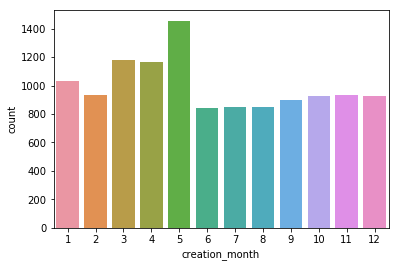

In [34]:
#look for any seasonal trends:

import seaborn as sns

sns.countplot("creation_month", data = final)

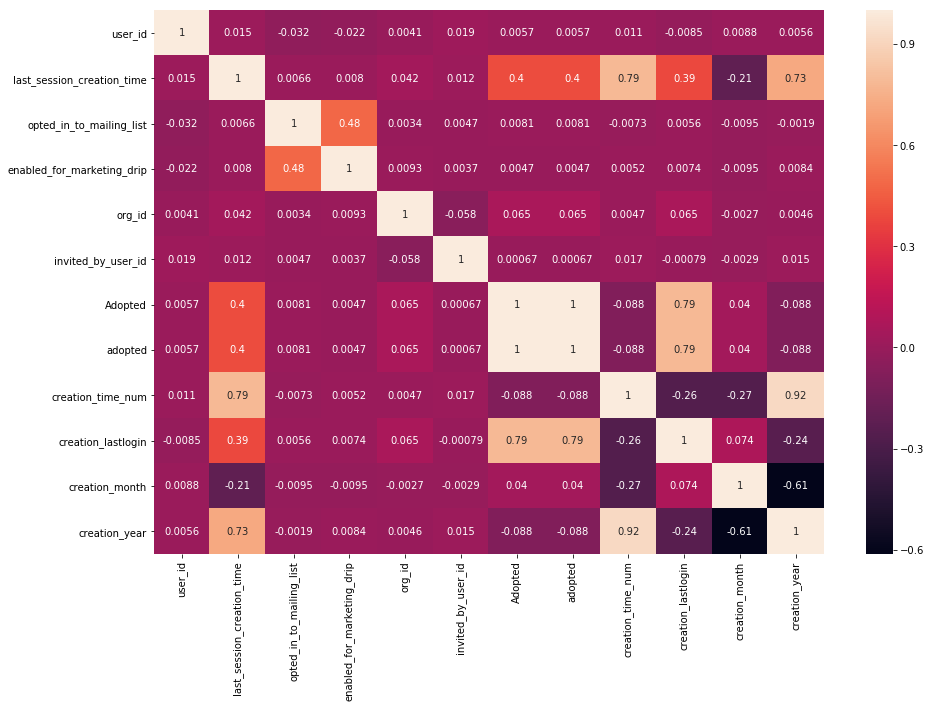

In [35]:
#look for any highly correlated features

cor = final.corr()
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(cor, annot=True, ax= ax)

Takeaways from correlation heatmap:
1. last_session_creation_time is correlated with many other variables.  Should exclude this.
2. opted_into_mailing_list is highly correlated with enabled_for_marketing_drip.  Drop the latter because it's less correlated with Y.
3. Don't include creation_year because it represents how long ago the user started, which can impact adoption too much.  Same reasoning for excluding creation_lastlogin, its correlation with Y is 0.8 -- too high!
4. Org_id looks like it could impact Y.  There are too many orgs though, so we'll need to bucket it into a categorical variable if we want to use it.

In [36]:
#bucket by org users
org_gb = users.groupby("org_id", as_index=False)["user_id"].count().sort_values(by="user_id", ascending=False)
bins = [0,100,200,300,400]
labels = [1,2,3,4]
org_gb["org_size"] = pd.cut(org_gb['user_id'], bins=bins, labels=labels)

In [37]:
org_gb.head(3)
#org_gb.drop(columns=["user_id"], inplace=True)
final = final.merge(org_gb, how="left", on = "org_id")

,org_id,user_id,org_size
0,0,319,4
1,1,233,3
2,2,201,3


In [ ]:
#save as new csv file
final.to_csv("asana.csv")